In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [13]:
# reflect an existing database into a new model
# Display the reflected table names
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

C:\Users\nedaj\AppData\Local\Temp\ipykernel_11464\2706964291.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [14]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [16]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [17]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [18]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()
print(most_recent_date)

('2017-08-23',)


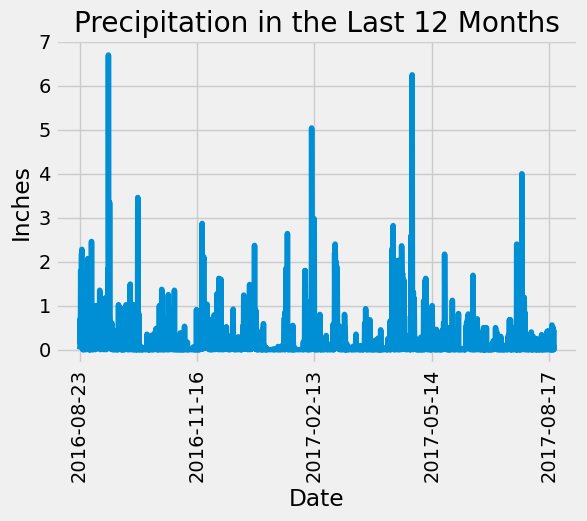

In [ ]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Finding the most recent date in the data set
most_recent_date = session.query(func.max(Measurement.date)).first()[0]

# Calculate the date one year from the last date in the data set
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)
one_year_ago = one_year_ago.strftime('%Y-%m-%d')  # Ensuring it's a string

# Perform a query to retrieve the data and precipitation scores
precipitation_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= one_year_ago)
    .all()
)
# Save the query results as a Pandas DataFrame
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Drop missing values
precipitation_df = precipitation_df.dropna()

# Sort the DataFrame by date
precipitation_df = precipitation_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.set_index('date', inplace=True)
ax = precipitation_df.plot(rot=90, figsize=(6, 4), legend=False)
plt.ylabel('Inches')
plt.xlabel('Date')
plt.title('Precipitation in the Last 12 Months')
plt.show()


In [30]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df.describe()

# Display the summary statistics
summary_statistics

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
total_stations

[(9,)]

In [33]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# Query to find the most active stations
most_active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

# Print the results
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [34]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Assuming most_active_stations contains the result of the previous query and we take the first result (most active station)
most_active_station_id = most_active_stations[0][0]

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    )
    .filter(Measurement.station == most_active_station_id)
    .all()
)

# Print the results
print(f"Lowest temperature: {temperature_stats[0][0]}")
print(f"Highest temperature: {temperature_stats[0][1]}")
print(f"Average temperature: {temperature_stats[0][2]}")

Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 71.66378066378067


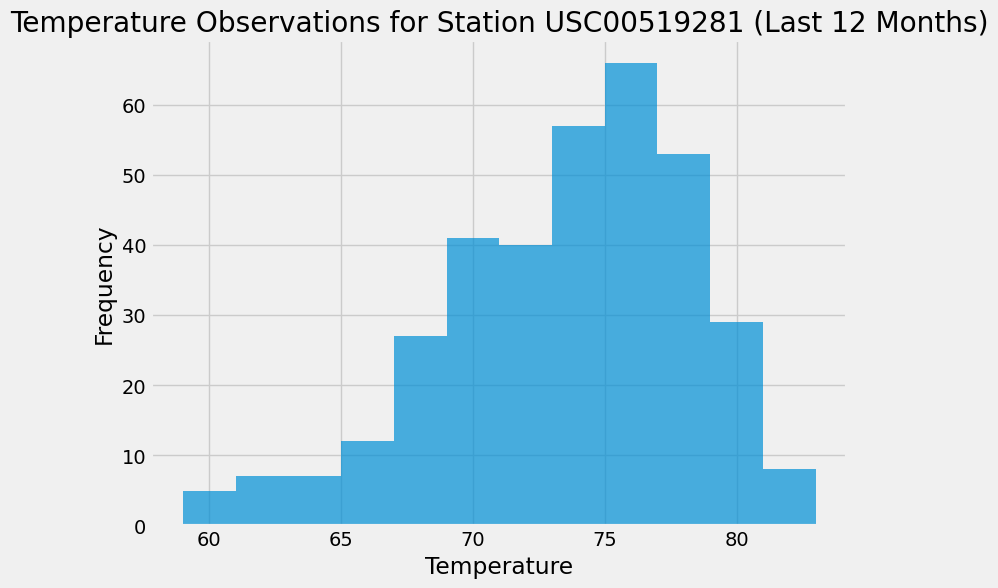

In [39]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Assuming most_active_station_id contains the ID of the most active station from the previous query

# Calculate the date one year ago from the most recent date in the dataset
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)
one_year_ago = one_year_ago.strftime('%Y-%m-%d')  # Convert to string

# Query the last 12 months of temperature observation data for the most active station
temperature_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station_id)
    .filter(Measurement.date >= one_year_ago)
    .all()
)

# Convert the results to a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['temperature'])

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperature_df['temperature'], bins=12, alpha=0.7)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {most_active_station_id} (Last 12 Months)')
plt.show()

# Close Session

In [40]:
# Close Session
session.close()